In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

import numpy as np
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split

In [6]:
dataset = np.load('../landmark_extraction_mechanism/dataset.npy', allow_pickle=True)

### Dataset shape
- dataset has `N` set of sequences (the number of videos processed).
- a set of sequences contains `sequence_length` (S) sets of landmarks
-a set of landmarks contains 58 float number that represent a posture.
```
dataset.shape = (N, S, 58)
```
In this case...
```
dataset.shape = (8, 10, 58)
```
*disclaimer*: the dataset contains numpy and python arrays so the `shape` attribute doesn't actually work

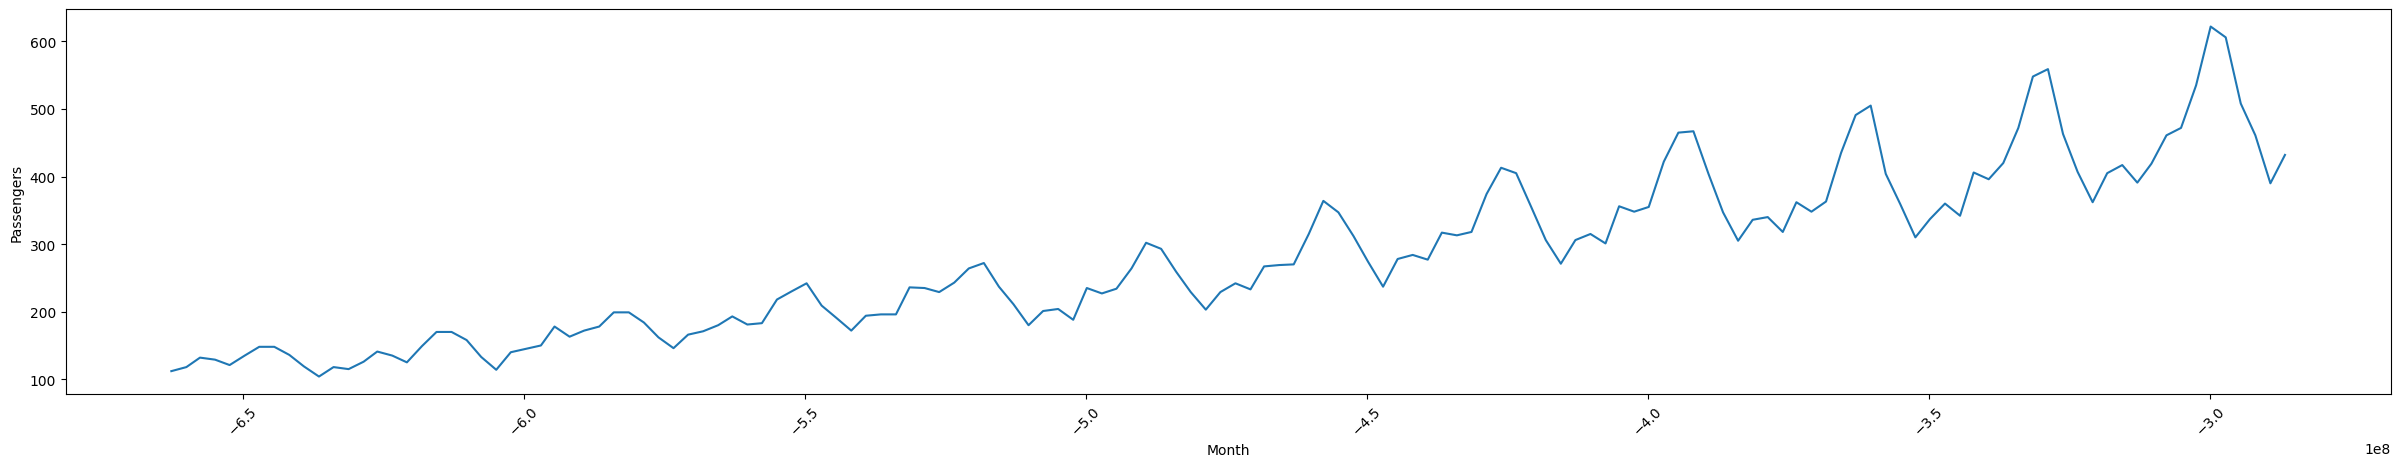

In [4]:
plt.figure(figsize=(30,5))
# Plot the data
plt.plot(df['Month'], df['Passengers'])

# Set the x-axis label and rotate it for readability
plt.xlabel('Month')
plt.xticks(rotation=45)

# Set the y-axis label
plt.ylabel('Passengers')

# Show the plot
plt.show()

In [5]:

train_df, test_df = train_test_split(df, test_size=0.33, random_state=42)

train_X = train_df['Month'].values.reshape(-1, 1)
train_y = train_df['Passengers'].values.reshape(-1, 1)

test_X = test_df['Month'].values.reshape(-1, 1)
test_y = test_df['Passengers'].values.reshape(-1, 1)


In [6]:
train_X = torch.tensor(train_X, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)

In [9]:

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out)  # Take the last time step's output
        return out


In [10]:
# Define your training data

# Create an instance of the AirModel
model = AirModel()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the number of training epochs
num_epochs = 100000

# Train the model
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(train_X)
    loss = criterion(outputs, train_y)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print training loss for every few epochs
    if (epoch+1) % int(num_epochs*0.25) == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(model.state_dict(), 'air_model.pth')

Epoch [25000/100000], Loss: 15448.4248
Epoch [50000/100000], Loss: 15364.0752
Epoch [75000/100000], Loss: 15323.7959
Epoch [100000/100000], Loss: 15295.6182


In [11]:

# Assuming 'test_X' and 'test_y' are your test data NumPy arrays
test_X = torch.tensor(test_X, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

# Set the model to evaluation mode
model.eval()

# Make predictions on the test set
with torch.no_grad():
    predicted_y = model(test_X)

# Calculate the accuracy
absolute_diff = torch.abs(predicted_y - test_y)
accuracy = 1.0 - torch.mean(absolute_diff / test_y)

print(f"Accuracy: {accuracy.item()*100:.2f}%")


Accuracy: 50.56%
